In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d drgfreeman/rockpaperscissors

 94% 289M/306M [00:02<00:00, 143MB/s]
100% 306M/306M [00:02<00:00, 120MB/s]


In [ ]:
!unzip "/content/rockpaperscissors.zip" -d "/content/dataset"

In [ ]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

**DATA PREPARATION**

In [ ]:
dataset_path = "/content/dataset/rps-cv-images"

CONFIG = {
    "IM_SIZE" : 256,
    "BATCH_SIZE" : 32,
}

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    subset="training",
    validation_split=0.2,
    shuffle = True,
    seed = 123
)

Found 2188 files belonging to 3 classes.
Using 1751 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"]),
    batch_size=CONFIG["BATCH_SIZE"],
    subset="validation",
    validation_split=0.2,
    shuffle = True,
    seed = 123
)

Found 2188 files belonging to 3 classes.
Using 437 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['paper', 'rock', 'scissors']


**DATA VISUALIZE**

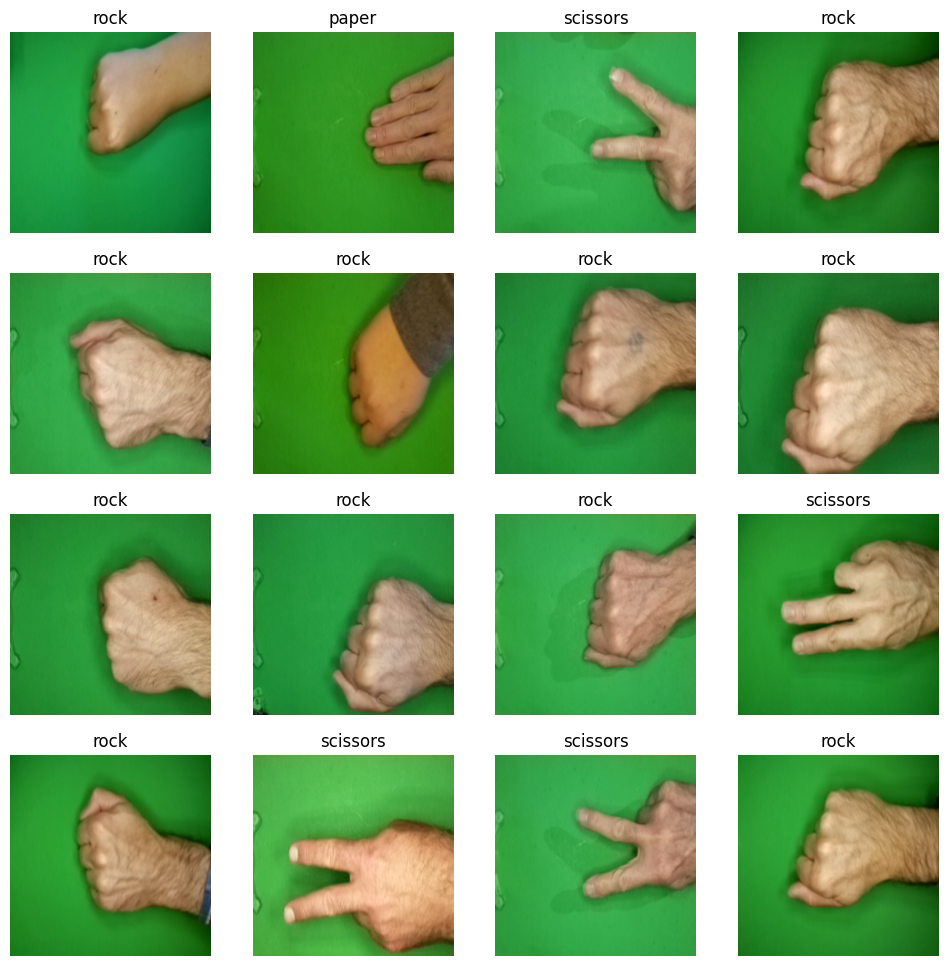

In [ ]:
plt.figure(figsize = (12,12))

for images,labels in train_ds.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title(class_names[labels[i].numpy()])
    plt.axis("off")

**DATA AUGMENTATION**

In [ ]:
data_augmentation_layer = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal", input_shape=(CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

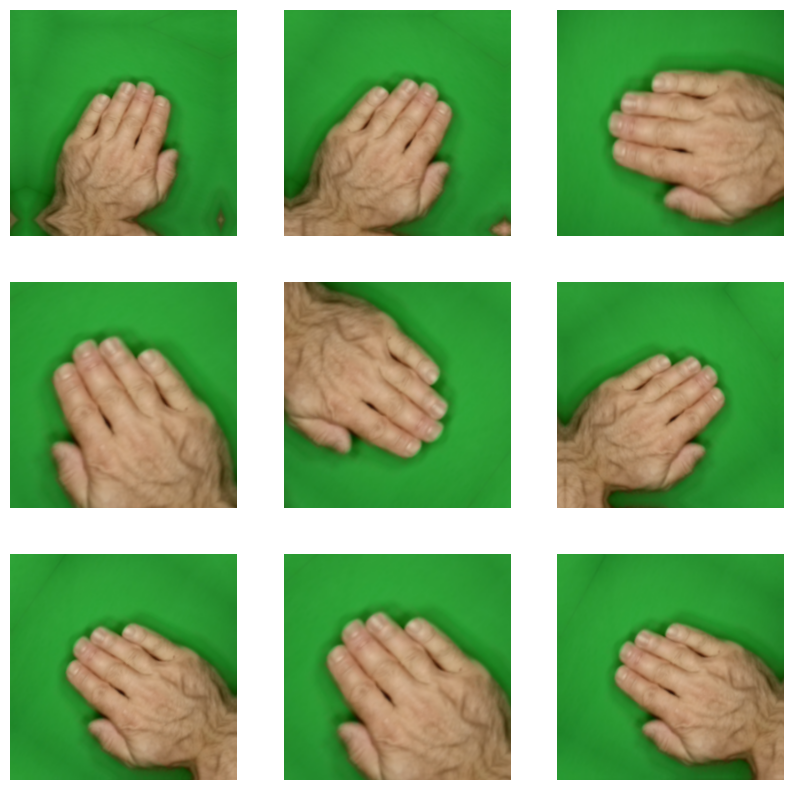

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(f"Train Size: {len(train_ds)}, Val size: {len(val_ds)}")
print(train_ds)
print(val_ds)

Train Size: 55, Val size: 14
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


**TRANSFER LEARNING WITH VGG16**

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)
)
vgg_backbone.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model = tf.keras.models.Sequential([
    vgg_backbone,
    layers.Flatten(),
    layers.Dense(1000,activation = "relu"),
    layers.Dropout(0.2),
    layers.Dense(len(class_names),activation="softmax")
])
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1000)              32769000  
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 47486691 (181.15 MB)
Trainable params: 32772003 (125.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
vgg_model.compile(optimizer="sgd",loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
history = vgg_model.fit(train_ds,validation_data=val_ds,epochs = 15)

Epoch 1/15
55/55 [==============================] - 30s 356ms/step - loss: 32.6711 - accuracy: 0.7304 - val_loss: 0.0373 - val_accuracy: 0.9886
Epoch 2/15
55/55 [==============================] - 18s 253ms/step - loss: 0.0351 - accuracy: 0.9874 - val_loss: 0.0269 - val_accuracy: 0.9931
Epoch 3/15
55/55 [==============================] - 16s 226ms/step - loss: 0.0110 - accuracy: 0.9971 - val_loss: 0.0208 - val_accuracy: 0.9931
Epoch 4/15
55/55 [==============================] - 19s 222ms/step - loss: 0.0101 - accuracy: 0.9971 - val_loss: 0.0119 - val_accuracy: 0.9954
Epoch 5/15
55/55 [==============================] - 15s 214ms/step - loss: 0.0083 - accuracy: 0.9966 - val_loss: 0.0180 - val_accuracy: 0.9954
Epoch 6/15
55/55 [==============================] - 18s 260ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 7/15
55/55 [==============================] - 15s 222ms/step - loss: 9.9636e-04 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0

In [ ]:
vgg_model.evaluate(val_ds)

14/14 [==============================] - 3s 162ms/step - loss: 0.0141 - accuracy: 0.9954


[0.014069953933358192, 0.9954233169555664]

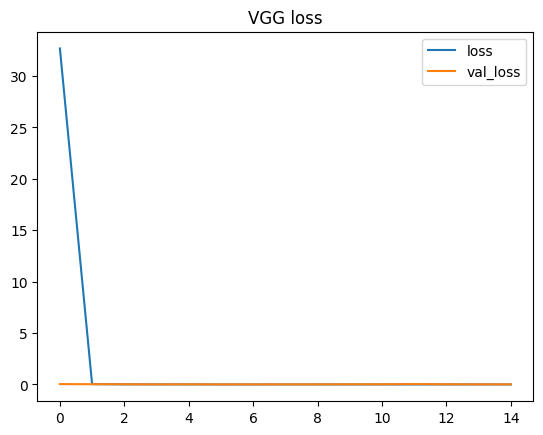

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("VGG loss")
plt.legend(["loss","val_loss"])
plt.show()

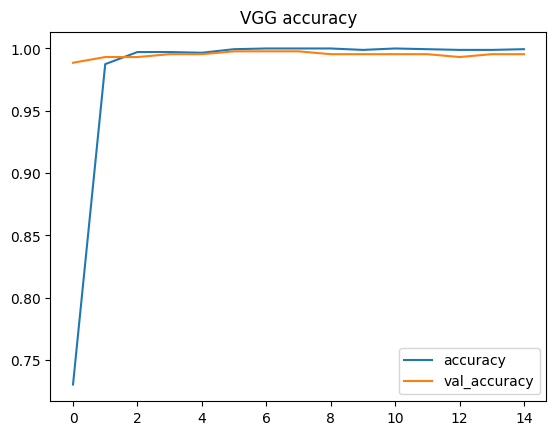

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("VGG accuracy")
plt.legend(["accuracy","val_accuracy"])
plt.show()

**SEQUENTIAL MODEL**

In [ ]:
model = tf.keras.models.Sequential([
    layers.Rescaling(1./255,input_shape = (CONFIG["IM_SIZE"],CONFIG["IM_SIZE"],3)),

    data_augmentation_layer,

    layers.Conv2D(filters = 32,kernel_size=3,strides = 1,padding = "valid",activation="relu"),
    layers.MaxPool2D(),

    layers.Conv2D(filters = 64,kernel_size=3,strides = 1,padding = "valid",activation="relu"),
    layers.MaxPool2D(),

    layers.Conv2D(filters = 128,kernel_size=3,strides = 1,padding = "valid",activation="relu"),
    layers.MaxPool2D(),

    layers.Dropout(0.3),


    layers.Flatten(),

    layers.Dense(128,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(len(class_names),activation="softmax"),

])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
model.compile(optimizer="adam",loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=10,batch_size= CONFIG["BATCH_SIZE"])

Epoch 1/10
55/55 [==============================] - 24s 155ms/step - loss: 1.1187 - accuracy: 0.3918 - val_loss: 0.8729 - val_accuracy: 0.5789
Epoch 2/10
55/55 [==============================] - 12s 156ms/step - loss: 0.8412 - accuracy: 0.6242 - val_loss: 0.5534 - val_accuracy: 0.8032
Epoch 3/10
55/55 [==============================] - 12s 126ms/step - loss: 0.6062 - accuracy: 0.7658 - val_loss: 0.4225 - val_accuracy: 0.8352
Epoch 4/10
55/55 [==============================] - 11s 148ms/step - loss: 0.4914 - accuracy: 0.8150 - val_loss: 0.2224 - val_accuracy: 0.9222
Epoch 5/10
55/55 [==============================] - 11s 127ms/step - loss: 0.4081 - accuracy: 0.8435 - val_loss: 0.3083 - val_accuracy: 0.8764
Epoch 6/10
55/55 [==============================] - 10s 126ms/step - loss: 0.3537 - accuracy: 0.8692 - val_loss: 0.1671 - val_accuracy: 0.9497
Epoch 7/10
55/55 [==============================] - 11s 139ms/step - loss: 0.2733 - accuracy: 0.9012 - val_loss: 0.1815 - val_accuracy: 0.9405

In [ ]:
model.evaluate(val_ds)

14/14 [==============================] - 1s 45ms/step - loss: 0.1374 - accuracy: 0.9565


[0.13744035363197327, 0.95652174949646]

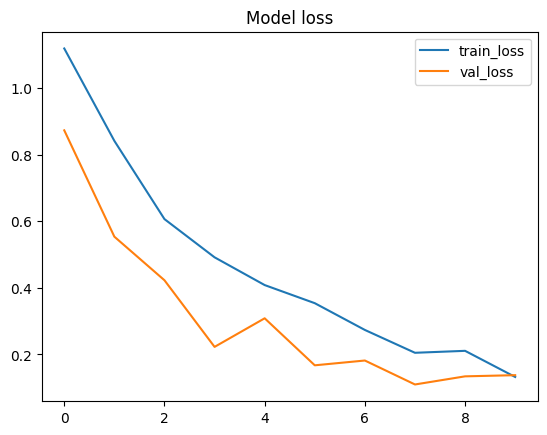

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title('Model loss')
plt.legend(["train_loss","val_loss"])
plt.show()

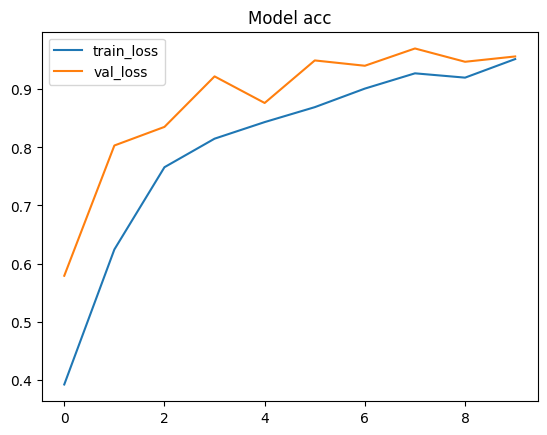

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title('Model acc')
plt.legend(["train_loss","val_loss"])
plt.show()

**PREDICT DATA**

1/1 [==============================] - 0s 18ms/step


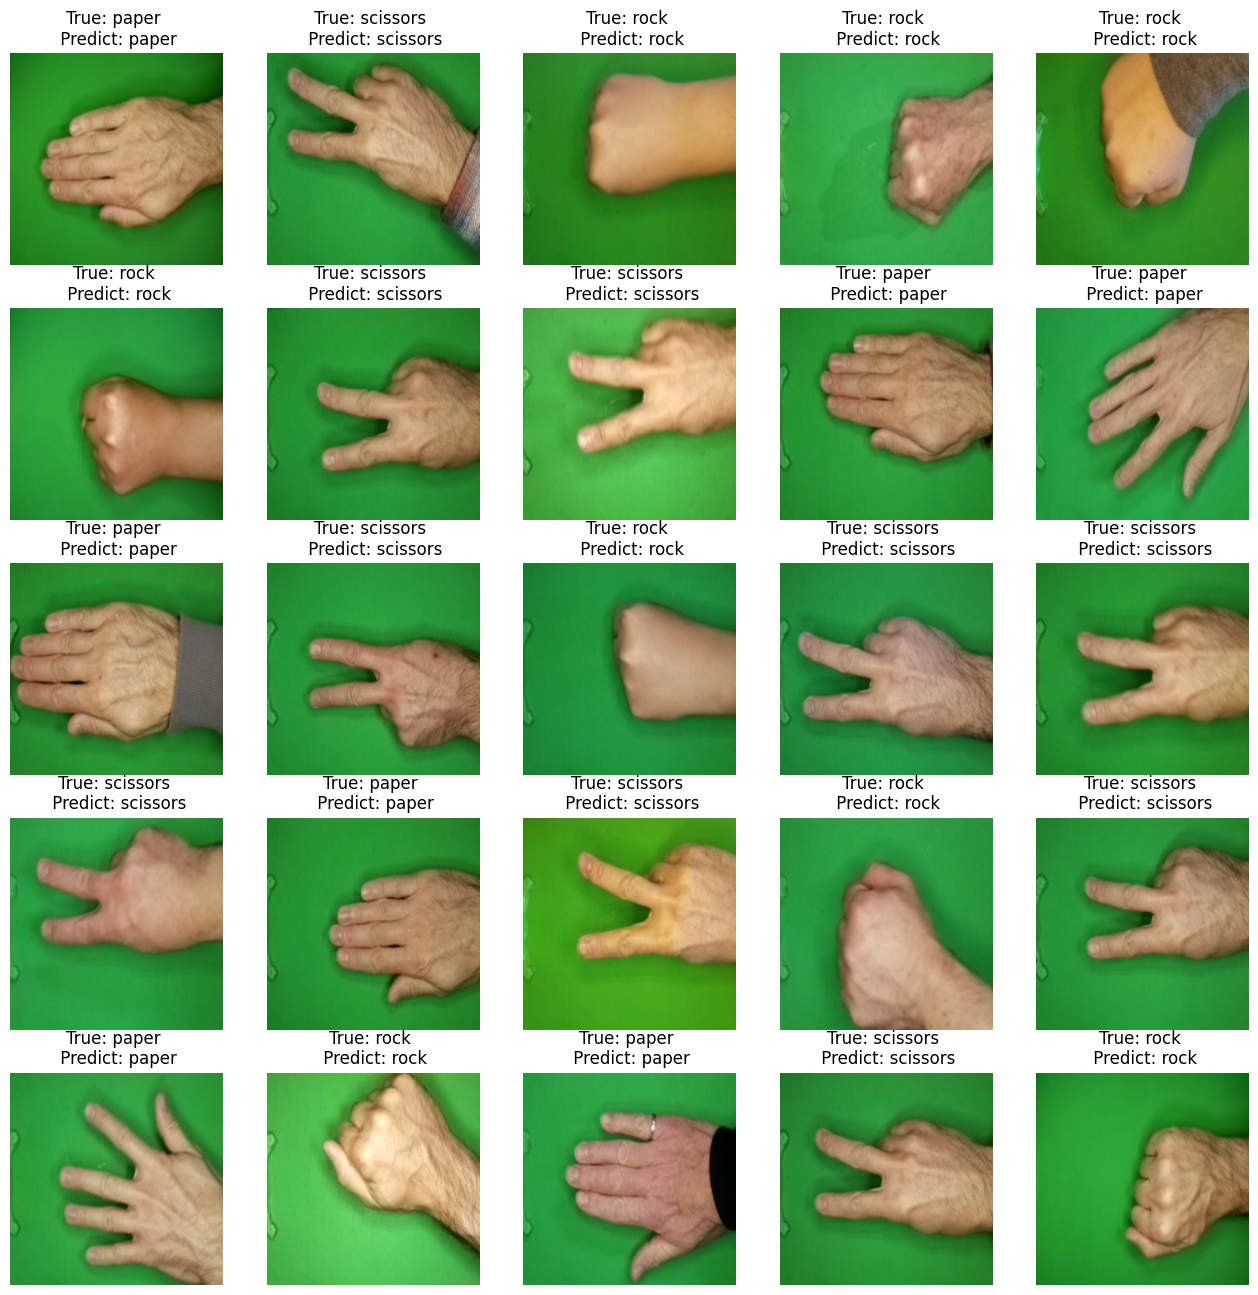

In [ ]:
plt.figure(figsize=(16,16))

for images,labels in val_ds.take(1):
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i]/255)
    true_label = class_names[labels[i].numpy()]
    img_arr = tf.expand_dims(images[i],axis = 0)
    prediction = np.argmax(vgg_model.predict(img_arr))
    plt.title(f"True: {true_label} \n Predict: {class_names[prediction]}")
    plt.axis("off")